In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colour import XYZ_to_Lab, delta_E, XYZ_to_RGB, RGB_to_XYZ
from colour.models import RGB_COLOURSPACE_sRGB
import tifffile
import zarr
from colour_lib.circle_process.rawparser import RawDataParser
from colour_lib.circle_process.circlelib import *

In [2]:
global_dir = "/uftp/src/"
rw = RawDataParser(reference_basepath=f"{global_dir}calibration_data/")

In [3]:
def image_read(sector, g1, g2, g3):
    store = tifffile.imread(
        f"{global_dir}Calib_{sector}_{g1}_{g2}_{g3}_202402.tif", aszarr=True
    )
    zarr_pyramids = zarr.open(store, mode="r")
    image = np.array(zarr_pyramids[3]) / 255
    gammas = [(g1 / 10), (g2 / 10), (g3 / 10)]
    image_revert = apply_gammaCorr(image, gammas)
    return image_revert

In [4]:
def coords_read(sz):
    return pd.read_csv(f"{global_dir}saved_coords/manual/huron0224/{sz}um_coords.csv")

In [5]:
images = {"R1_111": image_read("R1", 10, 10, 10)}
rads = {
    "4150": 40,
    "1000": 10,
    "750": 6,
    "500": 4,
    "400": 4,
    "300": 2,
    "250": 2,
    "200": 1,
    "150": 1,
    "CA1000": 50,
}
coords = {
    "4150": coords_read(4150),
    "1000": coords_read(1000),
    "750": coords_read(750),
    "500": coords_read(500),
    "400": coords_read(400),
    "300": coords_read(300),
    "250": coords_read(250),
    "200": coords_read(200),
    "150": coords_read(150),
    "CA1000": coords_read("CA1000"),
}

<tifffile.TiffPage 6 @11318147692> missing data offset tag


In [6]:
list(coords.items())[0][1].shape[0]

24

In [7]:
def draw_circle_mask(image, coord, radius):
    mask_shape = image.shape
    coords_y, coords_x = np.ogrid[: mask_shape[0], : mask_shape[1]]
    circle_mask = np.zeros(mask_shape[:2], dtype=bool)
    for idx, centroids in coord.iterrows():
        centroid_y, centroid_x = centroids["Y"], centroids["X"]
        circle_mask = circle_mask | (
            (coords_y - centroid_y) ** 2 + (coords_x - centroid_x) ** 2 <= radius**2
        )

    plt.imshow(image)
    plt.imshow(circle_mask, alpha=0.5)

In [8]:
CA = calc_rectangle(images["R1_111"], coords["CA1000"], rads["CA1000"])
slide = calc_rectangles(
    images["R1_111"],
    coords,
    rads,
    zones=["1000", "750", "500", "400", "300", "250", "200", "150"],
)

/home/gboykov/colour_project/src/colour_lib/circle_process/circlelib.py:66: RuntimeWarning: Mean of empty slice.
  mean_in_circle.append(channel_values.mean())
/home/gboykov/GBvenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
colour_arrays = {
    "exp_srgbs": calc_slide(CA, slide),
    "exp_xyz": Lindblooms(calc_slide(CA, slide), mode="RGBtoXYZ"),  # correctted
    "ref_srgbs": rw.get_reference_srgbs(),
    "ref_xyz": rw.get_reference_d65(),
}

In [10]:
from colour_lib.regressors.PLSregressor import PLSRegressor
from colour_lib.regressors.LassoRegressor import LassoRegressor
from colour_lib.regressors.StackedRegressor import StackedRegressor
from colour_lib.regressors.ThinPlateSpline import TPSRegressor

In [11]:
PLS_reg = PLSRegressor(colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"])
Lasso_reg = LassoRegressor(colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"], 0.01)
Test_reg = TPSRegressor(
    colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"], alpha=0.0
)

In [12]:
images["HS1 PLS reg"] = PLS_reg.predict(images["R1_111"])

In [13]:
images["HS1 Lasso reg"] = Lasso_reg.predict(images["R1_111"])

In [14]:
images["HS1 Test reg"] = Test_reg.predict(images["R1_111"])

In [15]:
CA = calc_rectangle(images["HS1 PLS reg"], coords["CA1000"], rads["CA1000"])
slide = calc_rectangle(images["HS1 PLS reg"], coords["1000"], rads["1000"])
colour_arrays["PLS_reg_srgbs"] = calc_slide(CA, slide)
CA = calc_rectangle(images["HS1 Lasso reg"], coords["CA1000"], rads["CA1000"])
slide = calc_rectangle(images["HS1 Lasso reg"], coords["1000"], rads["1000"])
colour_arrays["Lasso_reg_srgbs"] = calc_slide(CA, slide)
CA = calc_rectangle(images["HS1 Test reg"], coords["CA1000"], rads["CA1000"])
slide = calc_rectangle(images["HS1 Test reg"], coords["1000"], rads["1000"])
colour_arrays["Test_reg_srgbs"] = calc_slide(CA, slide)

/home/gboykov/colour_project/src/colour_lib/circle_process/circlelib.py:66: RuntimeWarning: Mean of empty slice.
  mean_in_circle.append(channel_values.mean())
/home/gboykov/GBvenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


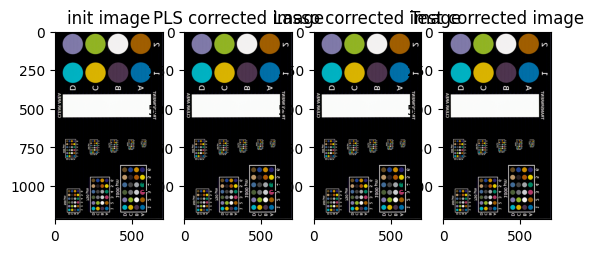

In [16]:
name_list = [
    ["R1_111", "init image"],
    ["HS1 PLS reg", "PLS corrected image"],
    ["HS1 Lasso reg", "Lasso corrected image"],
    ["HS1 Test reg", "Test corrected image"],
]

f, axarr = plt.subplots(1, 4)
for i, vector in enumerate(name_list):
    axarr[i].imshow(apply_gammaCorr(images[vector[0]], [1 / 2.2, 1 / 2.2, 1 / 2.2]))
    axarr[i].set_title(vector[1])

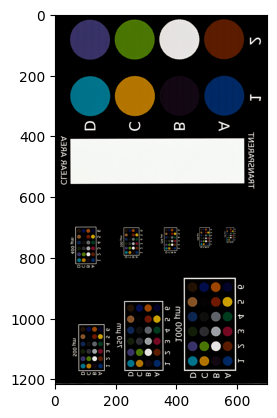

In [25]:
plt.imshow(images["R1_111"])

In [17]:
np.mean(
    calculate_delta_E(
        Lindblooms(colour_arrays["exp_srgbs"], mode="RGBtoXYZ"),
        colour_arrays["ref_xyz"],
    )
)

19.317053647597028

In [18]:
np.mean(
    calculate_delta_E(
        Lindblooms(colour_arrays["PLS_reg_srgbs"], mode="RGBtoXYZ"),
        colour_arrays["ref_xyz"],
    )
)

19.464722406175873

In [19]:
np.mean(
    calculate_delta_E(
        Lindblooms(colour_arrays["Lasso_reg_srgbs"], mode="RGBtoXYZ"),
        colour_arrays["ref_xyz"],
    )
)

19.464722406175873

In [20]:
np.mean(
    calculate_delta_E(
        Lindblooms(colour_arrays["Test_reg_srgbs"], mode="RGBtoXYZ"),
        colour_arrays["ref_xyz"],
    )
)

19.464722406175873

In [21]:
calculate_delta_E(
    Lindblooms(colour_arrays["exp_srgbs"], mode="RGBtoXYZ"), colour_arrays["ref_xyz"]
)

array([[ 14.73457723],
       [ 33.84234979],
       [ 17.63985152],
       [ 27.12315267],
       [ 29.54943094],
       [ 15.98294582],
       [ 10.39098676],
       [ 18.21389427],
       [ 17.10711787],
       [ 14.61852324],
       [ 11.57335711],
       [ 20.89292113],
       [ 20.9358704 ],
       [ 18.60883434],
       [ 15.50764821],
       [ 14.97804263],
       [ 11.97293763],
       [ 21.72586269],
       [ 34.7593304 ],
       [ 33.30713191],
       [  9.41287184],
       [  8.31040294],
       [ 21.97747996],
       [ 20.98305007],
       [ 18.77776984]])

In [22]:
calculate_delta_E(
    Lindblooms(colour_arrays["PLS_reg_srgbs"], mode="RGBtoXYZ"),
    colour_arrays["ref_xyz"],
)

array([[ 14.73457723],
       [ 33.81806754],
       [ 17.88216797],
       [ 28.80897034],
       [ 28.96277233],
       [ 15.85648651],
       [  9.47677418],
       [ 18.47745862],
       [ 16.95418366],
       [ 13.99396964],
       [ 10.62673809],
       [ 20.85260611],
       [ 20.77286561],
       [ 18.97000317],
       [ 15.28639167],
       [ 14.68085771],
       [ 14.9570807 ],
       [ 22.21444434],
       [ 34.37664461],
       [ 33.30546377],
       [  6.49408693],
       [  9.67192572],
       [ 25.57123069],
       [ 20.54222411],
       [ 19.33006891]])

In [23]:
calculate_delta_E(
    Lindblooms(colour_arrays["Lasso_reg_srgbs"], mode="RGBtoXYZ"),
    colour_arrays["ref_xyz"],
)

array([[ 14.73457723],
       [ 33.81806754],
       [ 17.88216797],
       [ 28.80897034],
       [ 28.96277233],
       [ 15.85648651],
       [  9.47677418],
       [ 18.47745862],
       [ 16.95418366],
       [ 13.99396964],
       [ 10.62673809],
       [ 20.85260611],
       [ 20.77286561],
       [ 18.97000317],
       [ 15.28639167],
       [ 14.68085771],
       [ 14.9570807 ],
       [ 22.21444434],
       [ 34.37664461],
       [ 33.30546377],
       [  6.49408693],
       [  9.67192572],
       [ 25.57123069],
       [ 20.54222411],
       [ 19.33006891]])

In [24]:
calculate_delta_E(
    Lindblooms(colour_arrays["Test_reg_srgbs"], mode="RGBtoXYZ"),
    colour_arrays["ref_xyz"],
)

array([[ 14.73457723],
       [ 33.81806754],
       [ 17.88216797],
       [ 28.80897034],
       [ 28.96277233],
       [ 15.85648651],
       [  9.47677418],
       [ 18.47745862],
       [ 16.95418366],
       [ 13.99396964],
       [ 10.62673809],
       [ 20.85260611],
       [ 20.77286561],
       [ 18.97000317],
       [ 15.28639167],
       [ 14.68085771],
       [ 14.9570807 ],
       [ 22.21444434],
       [ 34.37664461],
       [ 33.30546377],
       [  6.49408693],
       [  9.67192572],
       [ 25.57123069],
       [ 20.54222411],
       [ 19.33006891]])